# Random Forest Classifier

In [45]:
import gc
from joblib import dump

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from interpret.blackbox import LimeTabular, ShapKernel, PartialDependence, MorrisSensitivity

from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, balanced_accuracy_score,  f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [46]:
gc.collect()

851

In [47]:
set_visualize_provider(InlineProvider())

In [48]:
df = pd.read_csv("../../../data/combined_subjects.csv")

In [49]:
df.head()

Unnamed: 0  net_acc_mean  net_acc_std  net_acc_min  net_acc_max  \
0           0      1.331891     0.153556     1.014138     1.678399   
1           1      1.218994     0.090108     1.014138     1.485800   
2           2      1.143312     0.110987     0.948835     1.485800   
3           3      1.020669     0.135308     0.811090     1.239944   
4           4      0.887458     0.116048     0.727406     1.125306   

   EDA_phasic_mean  EDA_phasic_std  EDA_phasic_min  EDA_phasic_max  \
0         2.247876        1.112076        0.367977        4.459367   
1         1.781323        1.203991        0.232625        4.459367   
2         1.173169        1.285422        0.006950        4.459367   
3         0.311656        0.278650        0.006950        1.303071   
4         0.163826        0.110277        0.006950        0.369298   

   EDA_smna_mean  ...  ACC_z_min  ACC_z_max    0_mean     0_std     0_min  \
0       1.592308  ...  -0.000026   0.000060  0.027558  0.013523  0.000000   
1       1.347750  ...  -0.000026   0.000060  0.023420  0.015310  0.000000   
2       0.752335  ...  -0.000015   0.000049  0.018759  0.012604  0.000000   
3       0.198576  ...  -0.000005   0.000037  0.022888  0.012180  0.000688   
4       0.118080  ...   0.000002   0.000037  0.028105  0.010415  0.002752   

      0_max  BVP_peak_freq  TEMP_slope  subject  label  
0  0.087383       0.080556   -0.000102        2      1  
1  0.087383       0.144444   -0.000424        2      1  
2  0.071558       0.102778   -0.000814        2      1  
3  0.054356       0.108333   -0.000524        2      1  
4  0.054356       0.147222   -0.000165        2      1  

[5 rows x 45 columns]

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2091 non-null   int64  
 1   net_acc_mean     2091 non-null   float64
 2   net_acc_std      2091 non-null   float64
 3   net_acc_min      2091 non-null   float64
 4   net_acc_max      2091 non-null   float64
 5   EDA_phasic_mean  2091 non-null   float64
 6   EDA_phasic_std   2091 non-null   float64
 7   EDA_phasic_min   2091 non-null   float64
 8   EDA_phasic_max   2091 non-null   float64
 9   EDA_smna_mean    2091 non-null   float64
 10  EDA_smna_std     2091 non-null   float64
 11  EDA_smna_min     2091 non-null   float64
 12  EDA_smna_max     2091 non-null   float64
 13  EDA_tonic_mean   2091 non-null   float64
 14  EDA_tonic_std    2091 non-null   float64
 15  EDA_tonic_min    2091 non-null   float64
 16  EDA_tonic_max    2091 non-null   float64
 17  BVP_mean      

## Data Preparation

In [51]:
features = [
    "net_acc_std",
    "net_acc_max",
    "EDA_tonic_mean",
    "EDA_tonic_min",
    "EDA_tonic_max",
    "EDA_smna_mean",
    "EDA_smna_std",
    "EDA_smna_min",
    "EDA_smna_max",
    "EDA_phasic_min",
    "label"
]

In [52]:
df_feat = df[features]
df_feat.head()

net_acc_std  net_acc_max  EDA_tonic_mean  EDA_tonic_min  EDA_tonic_max  \
0     0.153556     1.678399        0.608263      -1.213173       2.554750   
1     0.090108     1.485800        0.731985      -1.213173       2.477276   
2     0.110987     1.485800        1.110242      -1.213173       2.037179   
3     0.135308     1.239944        1.598995       0.959752       2.037179   
4     0.116048     1.125306        1.342085       0.945946       2.037179   

   EDA_smna_mean  EDA_smna_std  EDA_smna_min  EDA_smna_max  EDA_phasic_min  \
0       1.592308      2.645333  3.096905e-08     17.418821        0.367977   
1       1.347750      2.666659  3.096905e-08     17.418821        0.232625   
2       0.752335      1.958546  3.096905e-08     17.418821        0.006950   
3       0.198576      0.413802  3.309990e-08      2.788862        0.006950   
4       0.118080      0.237575  2.787285e-08      1.300810        0.006950   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

### Merged Amusement

In [53]:
df_feat_merged_amusement = df_feat.copy()
df_feat_merged_amusement["label"] = df_feat_merged_amusement["label"].replace([0], 1)

In [54]:
df_feat_merged_amusement["label"].unique()

array([1, 2])

In [55]:
y_merged_amusement = np.array(df_feat_merged_amusement.pop('label'))
X_merged_amusement = np.array(df_feat_merged_amusement)

In [56]:
X_train_merged_amusement, X_test_merged_amusement, y_train_merged_amusement, y_test_merged_amusement = train_test_split(X_merged_amusement, y_merged_amusement, test_size=0.25, random_state=42)

### Dropped Amusement

In [57]:
df_feat_no_amusement = df_feat[df_feat["label"] != 0]

In [58]:
df_feat_no_amusement["label"].unique()

array([1, 2])

In [59]:
y_no_amusement = np.array(df_feat_no_amusement.pop('label'))
X_no_amusement = np.array(df_feat_no_amusement)

In [60]:
X_train_no_amusement, X_test_no_amusement, y_train_no_amusement, y_test_no_amusement = train_test_split(X_no_amusement, y_no_amusement, test_size=0.25, random_state=42)

## Training

In [61]:
parameters = dict(
    n_estimators=(25, 50, 75, 100, 125, 150),
    criterion=("gini", "entropy", "log_loss"),
    max_depth=(2, 3, 5, 7, 9, 11),
    random_state=(42,)
)

In [62]:
forest = RandomForestClassifier()

### Merged Amusement

In [63]:
clf_forest_merged_amusement = GridSearchCV(estimator=forest, param_grid=parameters)

In [64]:
clf_forest_merged_amusement.fit(X_train_merged_amusement, y_train_merged_amusement)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': (2, 3, 5, 7, 9, 11),
                         'n_estimators': (25, 50, 75, 100, 125, 150),
                         'random_state': (42,)})

In [65]:
clf_forest_merged_amusement.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=75,
                       random_state=42)

In [66]:
dump(clf_forest_merged_amusement.best_estimator_, "clf_forest_merged_amusement_top_10_feat.joblib")

['clf_forest_merged_amusement_top_10_feat.joblib']

### Dropped Amusement

In [67]:
clf_forest_no_amusement = GridSearchCV(estimator=forest, param_grid=parameters)

In [68]:
clf_forest_no_amusement.fit(X_train_no_amusement, y_train_no_amusement)

In [ ]:
clf_forest_no_amusement.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=125, random_state=42)

In [ ]:
dump(clf_forest_no_amusement.best_estimator_, "clf_forest_no_amusement_top_10_feat.joblib")

['clf_forest_no_amusement_top_10_feat.joblib']

## Evaluation

### Merged Amusement

In [ ]:
y_pred_merged_amusement = clf_forest_merged_amusement.predict(X_test_merged_amusement)

In [ ]:
accuracy_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9866156787762906

In [ ]:
balanced_accuracy_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9844209876094618

In [ ]:
f1_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9907038512616202

In [ ]:
precision_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9920212765957447

In [ ]:
recall_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9893899204244032

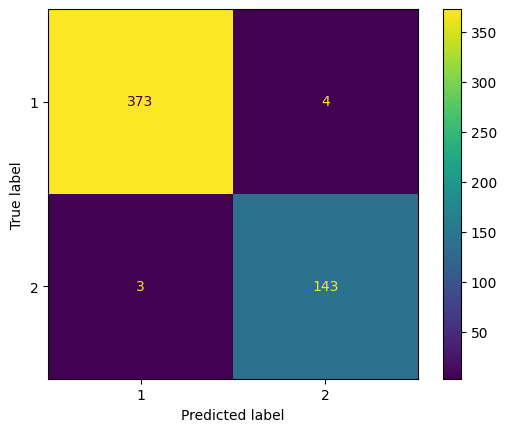

In [ ]:
cm = confusion_matrix(y_test_merged_amusement, y_pred_merged_amusement, labels=clf_forest_merged_amusement.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_forest_merged_amusement.best_estimator_.classes_)
disp.plot()
plt.show()

### Dropped Amusement

In [ ]:
y_pred_no_amusement = clf_forest_no_amusement.predict(X_test_no_amusement)

In [ ]:
accuracy_score(y_test_no_amusement, y_pred_no_amusement)

0.9795454545454545

In [ ]:
balanced_accuracy_score(y_test_no_amusement, y_pred_no_amusement)

0.9775964775964776

In [ ]:
f1_score(y_test_no_amusement, y_pred_no_amusement)

0.984822934232715

In [ ]:
precision_score(y_test_no_amusement, y_pred_no_amusement)

0.9864864864864865

In [ ]:
recall_score(y_test_no_amusement, y_pred_no_amusement)

0.9831649831649831

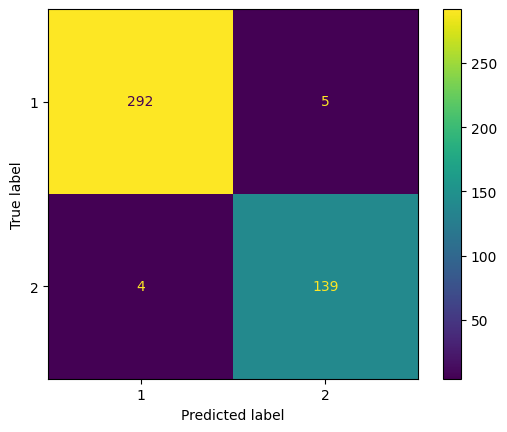

In [ ]:
cm = confusion_matrix(y_test_no_amusement, y_pred_no_amusement, labels=clf_forest_no_amusement.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_forest_no_amusement.best_estimator_.classes_)
disp.plot()
plt.show()

## XAI

### Merged Baseline

#### Morris Sensitivity Analysis

In [ ]:
msa = MorrisSensitivity(predict_fn=clf_forest_merged_amusement.best_estimator_.predict, data=X_train_merged_amusement, feature_names=features[:-1])
msa_global = msa.explain_global()
show(msa_global)

#### Shapley Additive Explanations

In [ ]:
shap = ShapKernel(predict_fn=clf_forest_merged_amusement.best_estimator_.predict, data=X_train_merged_amusement, feature_names=features[:-1])
shap_local = shap.explain_local(X_test_merged_amusement[:5], y_test_merged_amusement[:5])
show(shap_local)

Using 1568 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

#### Local Interpretable Model-agnostic Explanations

In [ ]:
lime = LimeTabular(predict_fn=clf_forest_merged_amusement.best_estimator_.predict, data=X_train_merged_amusement, feature_names=features[:-1])
lime_local = lime.explain_local(X_test_merged_amusement[:5], y_test_merged_amusement[:5])
show(lime_local)

#### Partial Dependence Plot

In [ ]:
pdp = PartialDependence(predict_fn=clf_forest_merged_amusement.best_estimator_.predict, data=X_train_merged_amusement, feature_names=features[:-1])
pdp_global = pdp.explain_global()
show(pdp_global)

KeyboardInterrupt: 

### Dropped Baseline

#### Morris Sensitivity Analysis

In [ ]:
msa = MorrisSensitivity(predict_fn=clf_forest_no_amusement.best_estimator_.predict, data=X_train_no_amusement, feature_names=features[:-1])
msa_global = msa.explain_global()
show(msa_global)

#### Shapley Additive Explanations

In [ ]:
shap = ShapKernel(predict_fn=clf_forest_no_amusement.best_estimator_.predict, data=X_train_no_amusement, feature_names=features[:-1])
shap_local = shap.explain_local(X_test_merged_amusement[:5], y_test_merged_amusement[:5])
show(shap_local)

Using 1568 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

#### Local Interpretable Model-agnostic Explanations

In [ ]:
lime = LimeTabular(predict_fn=clf_forest_no_amusement.best_estimator_.predict, data=X_train_no_amusement, feature_names=features[:-1])
lime_local = lime.explain_local(X_test_merged_amusement[:5], y_test_merged_amusement[:5])
show(lime_local)

#### Partial Dependence Plot

In [ ]:
pdp = PartialDependence(predict_fn=clf_forest_no_amusement.best_estimator_.predict, data=X_train_no_amusement, feature_names=features[:-1])
pdp_global = pdp.explain_global()
show(pdp_global)